<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>
# Modeling Atoms, Molecules and Crystals in One Dimension

## Example - Quantum Mechanics
<section class="post-meta">
by Jon Andreas StÃ¸vneng, Eilif Sommer Ã˜yre and Niels Henrik Aase
</section>
Last edited: March 21st 2019

___

This notebook is based on a numerical project [[1]](#rsc) created for TMA4320 *Introduction to Scientific Computation* and TFY4215 *Introduction to Quantum Physics* during the spring of 2019 at the Norwegian University of Science and Technology (NTNU).

___

## Introduction
In this notebook, we will solve the time independent SchrÃ¶dinger equation (TUSL),

\begin{equation}
H\psi = E\psi,
\label{TUSL}
\end{equation}

in one dimension using matrix diagonalisation. The method is the same as in [*Eigenenergies Through Matrix Diagonalization*](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/eigenenergies_through_matrix_diagonalization.ipynb#rsc), but will use a function from the scipy library and solve TUSL for several different potentials. In particular, we will look at a particle in a box, in a single potential well, in a double potential well, and in $N$ potential wells. The latter three potentials will give qualitative insight into the behaviour of an atom, molecule, and crystal, respectively. 

We assume noninteracting electrons with spin $\pm 1/2$. The electrons do obey the Pauli principle - only one electron in each state - which limits the amount of electrons occupying each orbital state to two, one with spin up ($+1/2$) and one with spin down ($-1/2$). Due to the limitations of a onedimensional system, some threedimensional features of the atom, molecule, and crystal are lost, e.g., angular momentum and degeneracy.

## Numerical method
For a particle with mass $m$ in one dimension, TUSL becomes

$$-\frac{\hbar^2}{2m} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi(x) = E \psi(x).$$

Next, by discretising the kinetic and potential energy operators

$$
\begin{align}
\psi_n &= \psi(x_n) = \psi(n\cdot \Delta x) \\
V_n &= V(x_n) ,
\end{align}
$$

the equation can be rewritten as
$$
\begin{equation}
-\frac{\hbar^2}{2m} \frac{\psi_{n+1}-2\psi_n+\psi_{n-1}}{(\Delta x)^2} + V_n \psi_n = E \psi_n.
\label{discret}
\end{equation}
$$
To fix the position of the particle on a finite interval on the $x$-axis of length $L = (N + 1)\Delta x$, choose $V_0 = \infty$ and $V_{N+1} = \infty$ such that $\psi$ is nonzero only at $1 \le n \le N$. This results in $N$ difference equations

$$ \textbf{H}\vec{\psi} = E\vec{\psi} ,$$

where $\textbf{H}$ is a $N \times N$ real, symmetric, tridiagonal matrix on the form

\begin{equation} \textbf{H} = 
\begin{bmatrix} 
\frac{\hbar^2}{m(\Delta x)^2} + V_1 & -\frac{\hbar^2}{2m(\Delta x)^2} & 0 & 0 & 0 \\
-\frac{\hbar^2}{2m(\Delta x)^2} & \frac{\hbar^2}{m(\Delta x)^2} + V_2 & -\frac{\hbar^2}{2m(\Delta x)^2} & 0 & 0 \\
0 & \ddots & \ddots & \ddots & 0 \\
0 & 0 & -\frac{\hbar^2}{2m(\Delta x)^2} & \frac{\hbar^2}{m(\Delta x)^2} + V_{N-1} & -\frac{\hbar^2}{2m(\Delta x)^2}\\
0 & 0 & 0 & -\frac{\hbar^2}{2m(\Delta x)^2} & \frac{\hbar^2}{m(\Delta x)^2} + V_{N}
\end{bmatrix},
\end{equation}

and $E$ is a diagonal $N\times N$ matrix

\begin{equation} E = 
\begin{bmatrix} E & 0 & 0 \\
                0 & \ddots & 0 \\
                0 & 0 & E
\end{bmatrix}.
\end{equation}

We have non-trivial solutions, $\vec{\psi} \ne 0$, if the N-th degree polynomial

$${\rm det}(\textbf{H} - E) = 0 = c_N E^N + c_{N-1} E^{N-1} + \dots + c_1 E + c_0,$$

with coefficients $c_N, c_{N-1}, ..., c_0$, is equal to zero. The polynomial has $N$ solutions $E_1$, $E_2$, $\dots$ , $E_N$ with corresponding eigenvectors $\vec{\psi}^{(1)}$, $\vec{\psi}^{(2)}$, $\dots$, $\vec{\psi}^{(N)}$, such that

$$(\textbf{H} - E_j)\vec{\psi}^{(j)} = 0 \;\;\; ; \;\;\; j = 1,2,\dots,N.$$

The normalisation of the wave functions

$$\int_{-\infty}^{\infty} |\psi^{(j)}(x)|^2\,dx = 1,$$

corresponds in the discrete case to

$$\sum_{n=1}^{N} |\psi_n^{(j)}|^2 = 1 \;\;\; ; \;\;\; j = 1,2,\dots,N,$$

where $\psi_n^{(j)} = \psi^{(j)}(x_n)$ is the value of wave function $j$ in the position $x_n = n\,\Delta x$. 

Assuming the wave functions are real, we can write the orthonormality relation as

$$\sum_{n=1}^{N} \psi_n^{(k)} \psi_n^{(j)} = \delta_{kj}$$

and the completeness relation as

$$\sum_{j=1}^{N} \psi_n^{(j)} \psi_k^{(j)} = \delta_{nk},$$

where $\delta_{kj}$ is the Kronecker-delta

\begin{equation} \delta_{kj} = 
\begin{cases} 0, \; \text{if}\; k \ne j \\
              1, \; \text{if}\; k = j
\end{cases}.
\end{equation}

## Implementation

The procedure of finding the eigenvalues of $\textbf{H}$ after defining its elements is fairly simple by using the computational tool `scipy`. The function `scipy.linalg.eigh_tridiagonal` finds the eigenvalues of a real, symmetric, tridiagonal matrix given the elements of the diagonals.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Define constants
hbar = 1.05E-34     # Reduced Planck constant
m = 9.11E-31        # Mass of particle, in this case an electron
V0 = -10.0*1.6E-19  # Depth of potential well

### Particle in a Box
A potential 

$$ V(x) = 0 \;\;\text{for}\;\; 0 < x < L \;\;\implies\;\; V_n = 0 \;\;\text{for}\;\; 1 < n < N $$

corresponds to an infinite potential well, or a *particle in a box*. For this potential, the time independent SchrÃ¶dinger equation has the analytical solution

$$ \psi_j(x) = \sqrt{\frac{2}{L}}\sin k_j x \;\; \text{with}\;\; E_j = \frac{\hbar^2 k_j^2}{2m} \; ; \; k_j = \frac{j\pi}{L} .$$

This gives us the opportunity to check if our numerical method is valid.

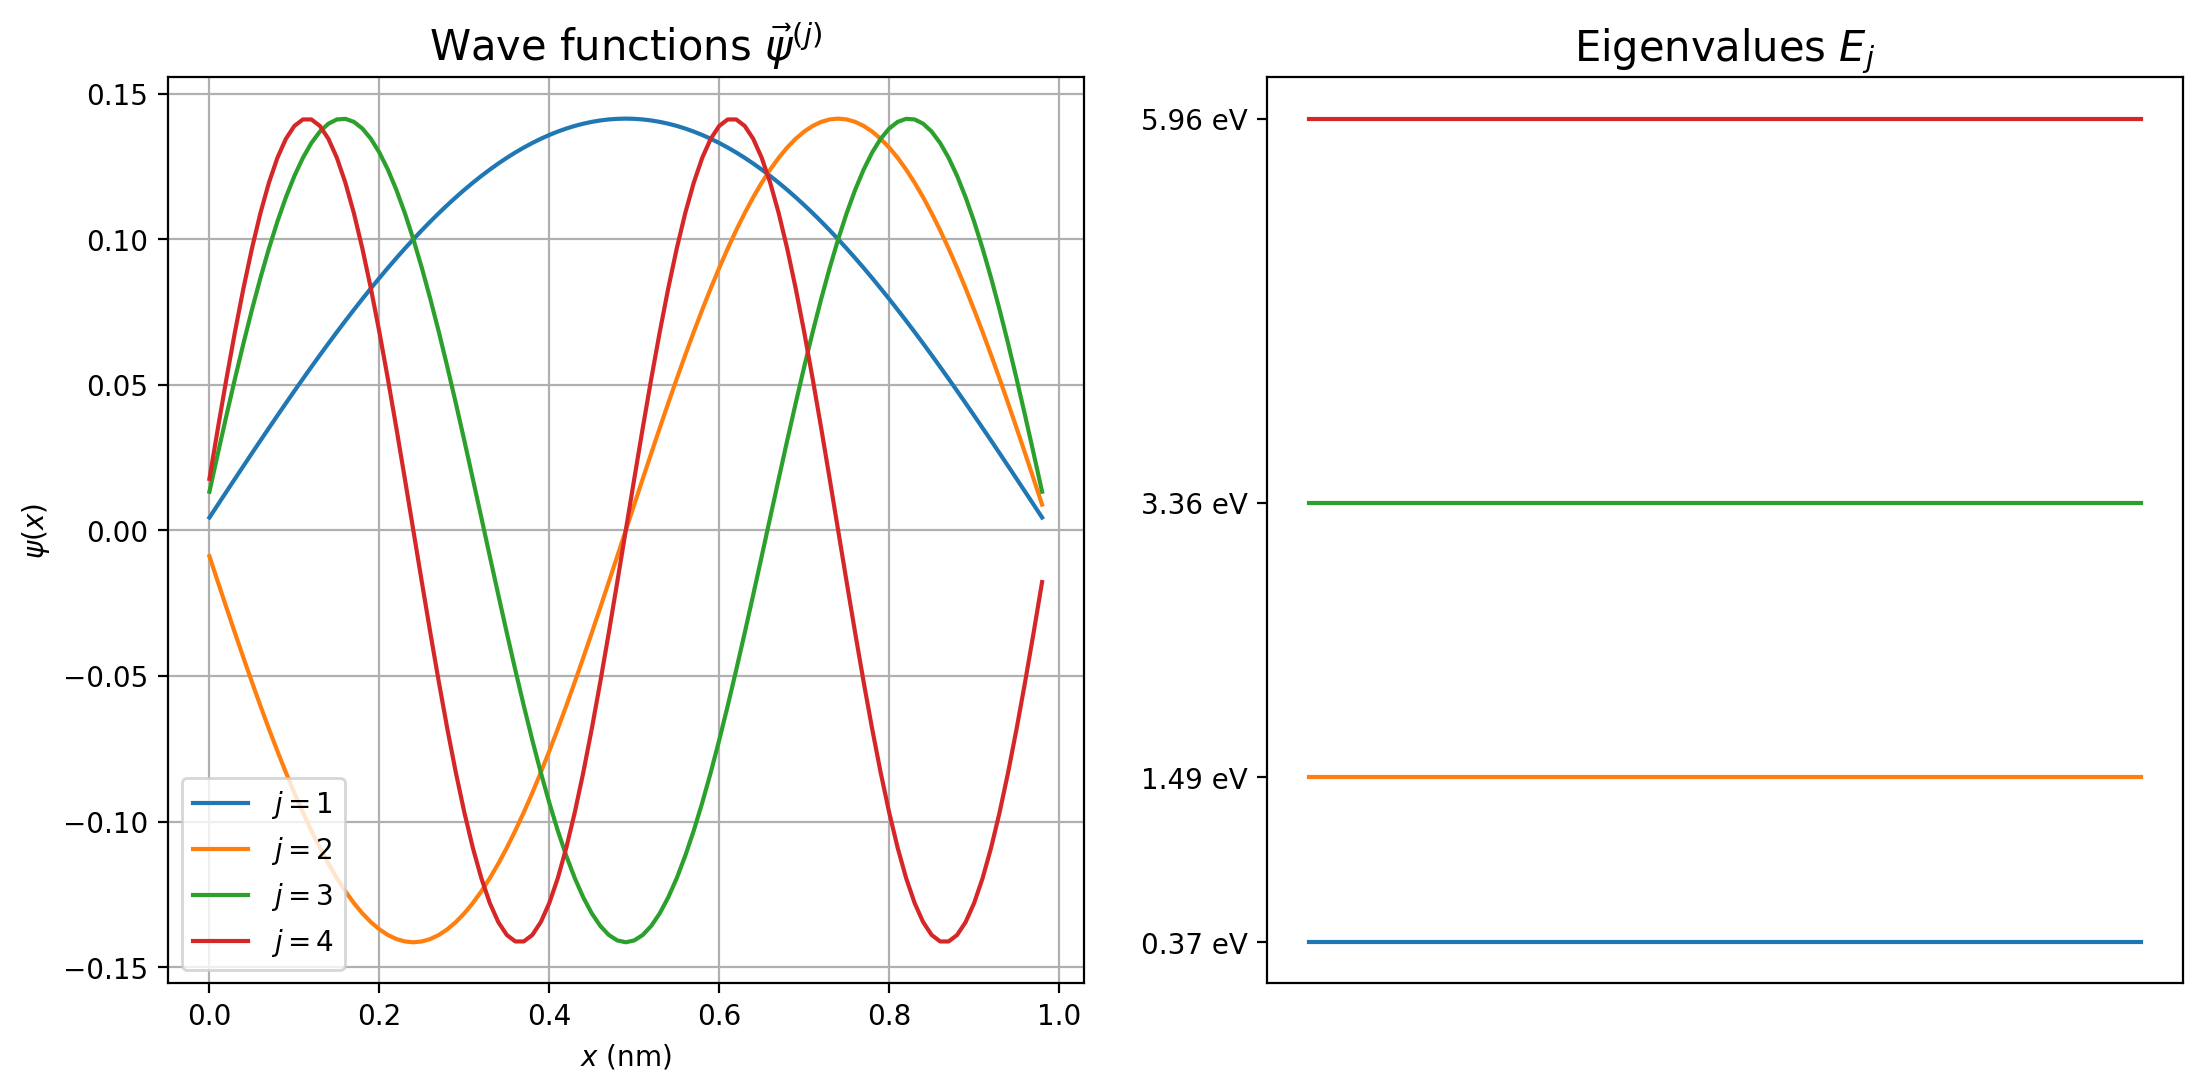

In [2]:
dx = 1.0E-11    # Discretisation step length
N = 99          # Number of discretisation steps
V = np.zeros(N) # Potential

def solveSchrodinger(V):
    """Given the potential, V(x), solves the one dimensional time 
    independent SchrÃ¶dinger equation using matrix diagonalisation 
    and returns the eigenvectors and corresponding eigenvalues (in eV).
    Also returns the discrete x-values of the eigenvectors
    in nanometer in the array xnm.
    """
    Ntot = len(V)
    # Position values
    x = np.array([dx*n for n in range(Ntot)])
    # convert to nanometer [nm]
    xnm = x*1.0E9

    # Array of the diagonal elements of H
    mainDiag = [v + hbar**2/(m*dx**2) for v in V]
    # Array of the above/below diagonal elements of the main diagonal of H
    secondDiag = [-hbar**2/(2*m*dx**2)]*(Ntot-1)

    # Finding the eigenvalues and eigenvectors of the H-matrix         
    eigVal, eigVec = linalg.eigh_tridiagonal(mainDiag, secondDiag) # eigVec[j, n], eigVal[j]
    # Convert to electronvolt [eV]
    eigVal *= 1/1.60E-19
    
    return eigVec, eigVal, xnm


eigVec, eigVal, xnm = solveSchrodinger(V)

def plotEigenValues(n, eigVal, xnm, plotPotential, V):
    """Plots the n lowest eigenvalues."""
    plt.title(r'Eigenvalues $E_j$', fontsize=15)
    if plotPotential:
        # Plots the potential
        plt.plot(xnm, V/1.6E-19, label=r'$V(x)$')
    for i in range(n):
        plt.plot(xnm, [eigVal[i]]*len(xnm), label=r'$j = $%.i'%(i))
    # Manually define the y-axis points
    plt.yticks((eigVal[0], eigVal[1], eigVal[2], eigVal[3]), 
               ('%.2f eV'%(eigVal[0]), '%.2f eV'%(eigVal[1]), 
                '%.2f eV'%(eigVal[2]), '%.2f eV'%(eigVal[3])), fontsize=10)
    plt.xticks((), ())
    
def plotEigenVectors(n1, n2, eigVec, xnm):
    """Plots eigenvectors n1 to n2"""
    plt.title(r'Wave functions $\vec{\psi}^{(j)}$', fontsize=15)
    for i in range(n1, n2+1):
        plt.plot(xnm, eigVec[:, i], label=r'$j = $%.i'%(i + 1))
    plt.xlabel('$x$ (nm)')
    plt.ylabel('$\psi(x)$')
    plt.grid(True)
    plt.legend(loc='best')
    
# Plot the four lowest eigenvectors
plt.figure("Box Potential", figsize=(13, 6), dpi=(200))
plt.subplot(121)
plotEigenVectors(0, 3, eigVec, xnm)

# Plot the four lowest eigenvalues
plt.subplot(122)
plotEigenValues(4, eigVal, xnm, False, 0)

plt.show()

Evidently, the numerical wave functions in the plot resemble the analytical solutions. What about the eigenvalues?

In [3]:
def E_analytical(j):
    """Function that returns the analytical eigenvalue of a
    particle in a box. The parameter j is the quantum number
    """
    # Length of box
    L = (N + 1)*dx
    k = j*np.pi/L
    E = hbar**2*k**2/(2*m)
    return E/1.60E-19

# The ground state energy
E_1 =  E_analytical(1)

print("\t\t E_1 \t\t E_2 \t\t E_3 \t\t E_4")
print("Numerical \t %.6f eV \t %.6f eV \t %.6f eV \t %.6f eV"
      %(eigVal[0], eigVal[1], eigVal[2], eigVal[3]))
print("Analytical \t %.6f eV \t %.6f eV \t %.6f eV \t %.6f eV"
      %(E_1, E_analytical(2), E_analytical(3), E_analytical(4)))

		 E_1 		 E_2 		 E_3 		 E_4
Numerical 	 0.373228 eV 	 1.492544 eV 	 3.356843 eV 	 5.964285 eV
Analytical 	 0.373259 eV 	 1.493035 eV 	 3.359329 eV 	 5.972140 eV


In [4]:
# Are the wavefunctions normalised?
norm = eigVec**2
print("Average norm:", np.sum(norm)/N)

# Are they orthogonal?
ortogSum = 0
for n in range(N):
    for q in range(N):
        if n != q:
            ortogSum += np.sum(eigVec[:, n]*eigVec[:, q])
            
print("Orthogonality sum:", ortogSum)

# Do they satisfy the completeness relation?
completSum = 0
for n in range(N):
    for q in range(N):
        if n != q:
            ortogSum += np.sum(eigVec[n, :]*eigVec[q, :])
            
print("Completeness sum:", completSum)

Average norm: 1.0
Orthogonality sum: -3.4229523648019247e-13
Completeness sum: 0


The eigenfunctions are orthonormal and form a complete set. How does the error in $E$ decrease with decreasing step size?

In [5]:
print("Log Error for Log dx = %.1E:\t%.1E "%(np.log10(dx), np.log10(np.abs(E_1 - eigVal[0]))))

# Re-calculate eigenenergies
N = 999
dx = 1.0E-12
V2 = np.zeros(N)
eigVec2, eigVal2, xnm2 = solveSchrodinger(V2)
print("Log Error for Log dx = %.1E:\t%.1E "%(np.log10(dx), np.log10(np.abs(E_1 - eigVal2[0]))))

# Re-calculate eigenenergies
N = 9999
dx = 1.0E-13
V3 = np.zeros(N)
eigVec3, eigVal3, xnm3 = solveSchrodinger(V3)
print("Log Error for Log dx = %.1E:\t%.1E "%(np.log10(dx), np.log10(np.abs(E_1 - eigVal3[0]))))

Log Error for Log dx = -1.1E+01:	-4.5E+00 
Log Error for Log dx = -1.2E+01:	-6.5E+00 
Log Error for Log dx = -1.3E+01:	-8.5E+00 


This shows that the error in $E_1$ is second order in $dx$.

### The Atom

Wave functions and energy levels from a single potential well can qualitatively describe the behaviour of electrons in an atom.
It can be shown that the number of bound states, $N_{bound}$ in the potential well $V_0$ is given by [[2]](#rsc)

\begin{equation}
N_{bound} = 1 + \big[ \sqrt{2m|V_0|} \frac{w}{\pi \hbar}\big],
\end{equation}

where the term within the bracket is rounded down to the nearest integer. With well potential $V_0 = -10 \text{ eV}$ and well width $w = 0.5 \text{ nm}$ we get 3 bound states for the electron. On each side of the well a zero potential region of width $10w$ is added as a "contact".  Another interesting property of the system is the penetration depth, here given analytically as 

\begin{equation}
\kappa^{-1} = \frac{\hbar}{\sqrt{2m(|V_0|-|E|)}}.
\end{equation}

Since $V_0$ is chosen negative, bound state energies are also negative; hence the absolute values.
We can compare our numerical result with analytical values if the penetration into the contacts is not too large, $\kappa^{-1} \ll 10w$.
Analytically, symmetric and antisymmetric wave functions correspond to energy eigenvalues given by

\begin{equation}
\tan\frac{\sqrt{2m|E|}w}{2\hbar} =
        \begin{cases}
        \sqrt{\frac{|V_0| - |E|}{|E|}} \; ; \; \text{Symmetric wave functions}\\
        -\sqrt{\frac{|E|}{|V_0| - |E|}} \; ; \; \text{Antisymmetric wave functions}.
        \end{cases}
\label{analyticalRelation}
\end{equation}

Checking the correspondence for the left and right hand side is a nice sanity check for our model.

In addition, using that the kinetic energy $K$ is $p^2/2m = E - V$ and the momentum relation $p = \hbar k = h/\lambda$, we get the following expression for the wavelength:

\begin{equation}
\frac{h^2}{\lambda^2 2 m}Â = E - V \; \implies \; \lambda = \frac{2 \pi \hbar }{\sqrt{2 m (E - V)}},
\label{wavelength}
\end{equation}

where $h =2\pi\hbar$.

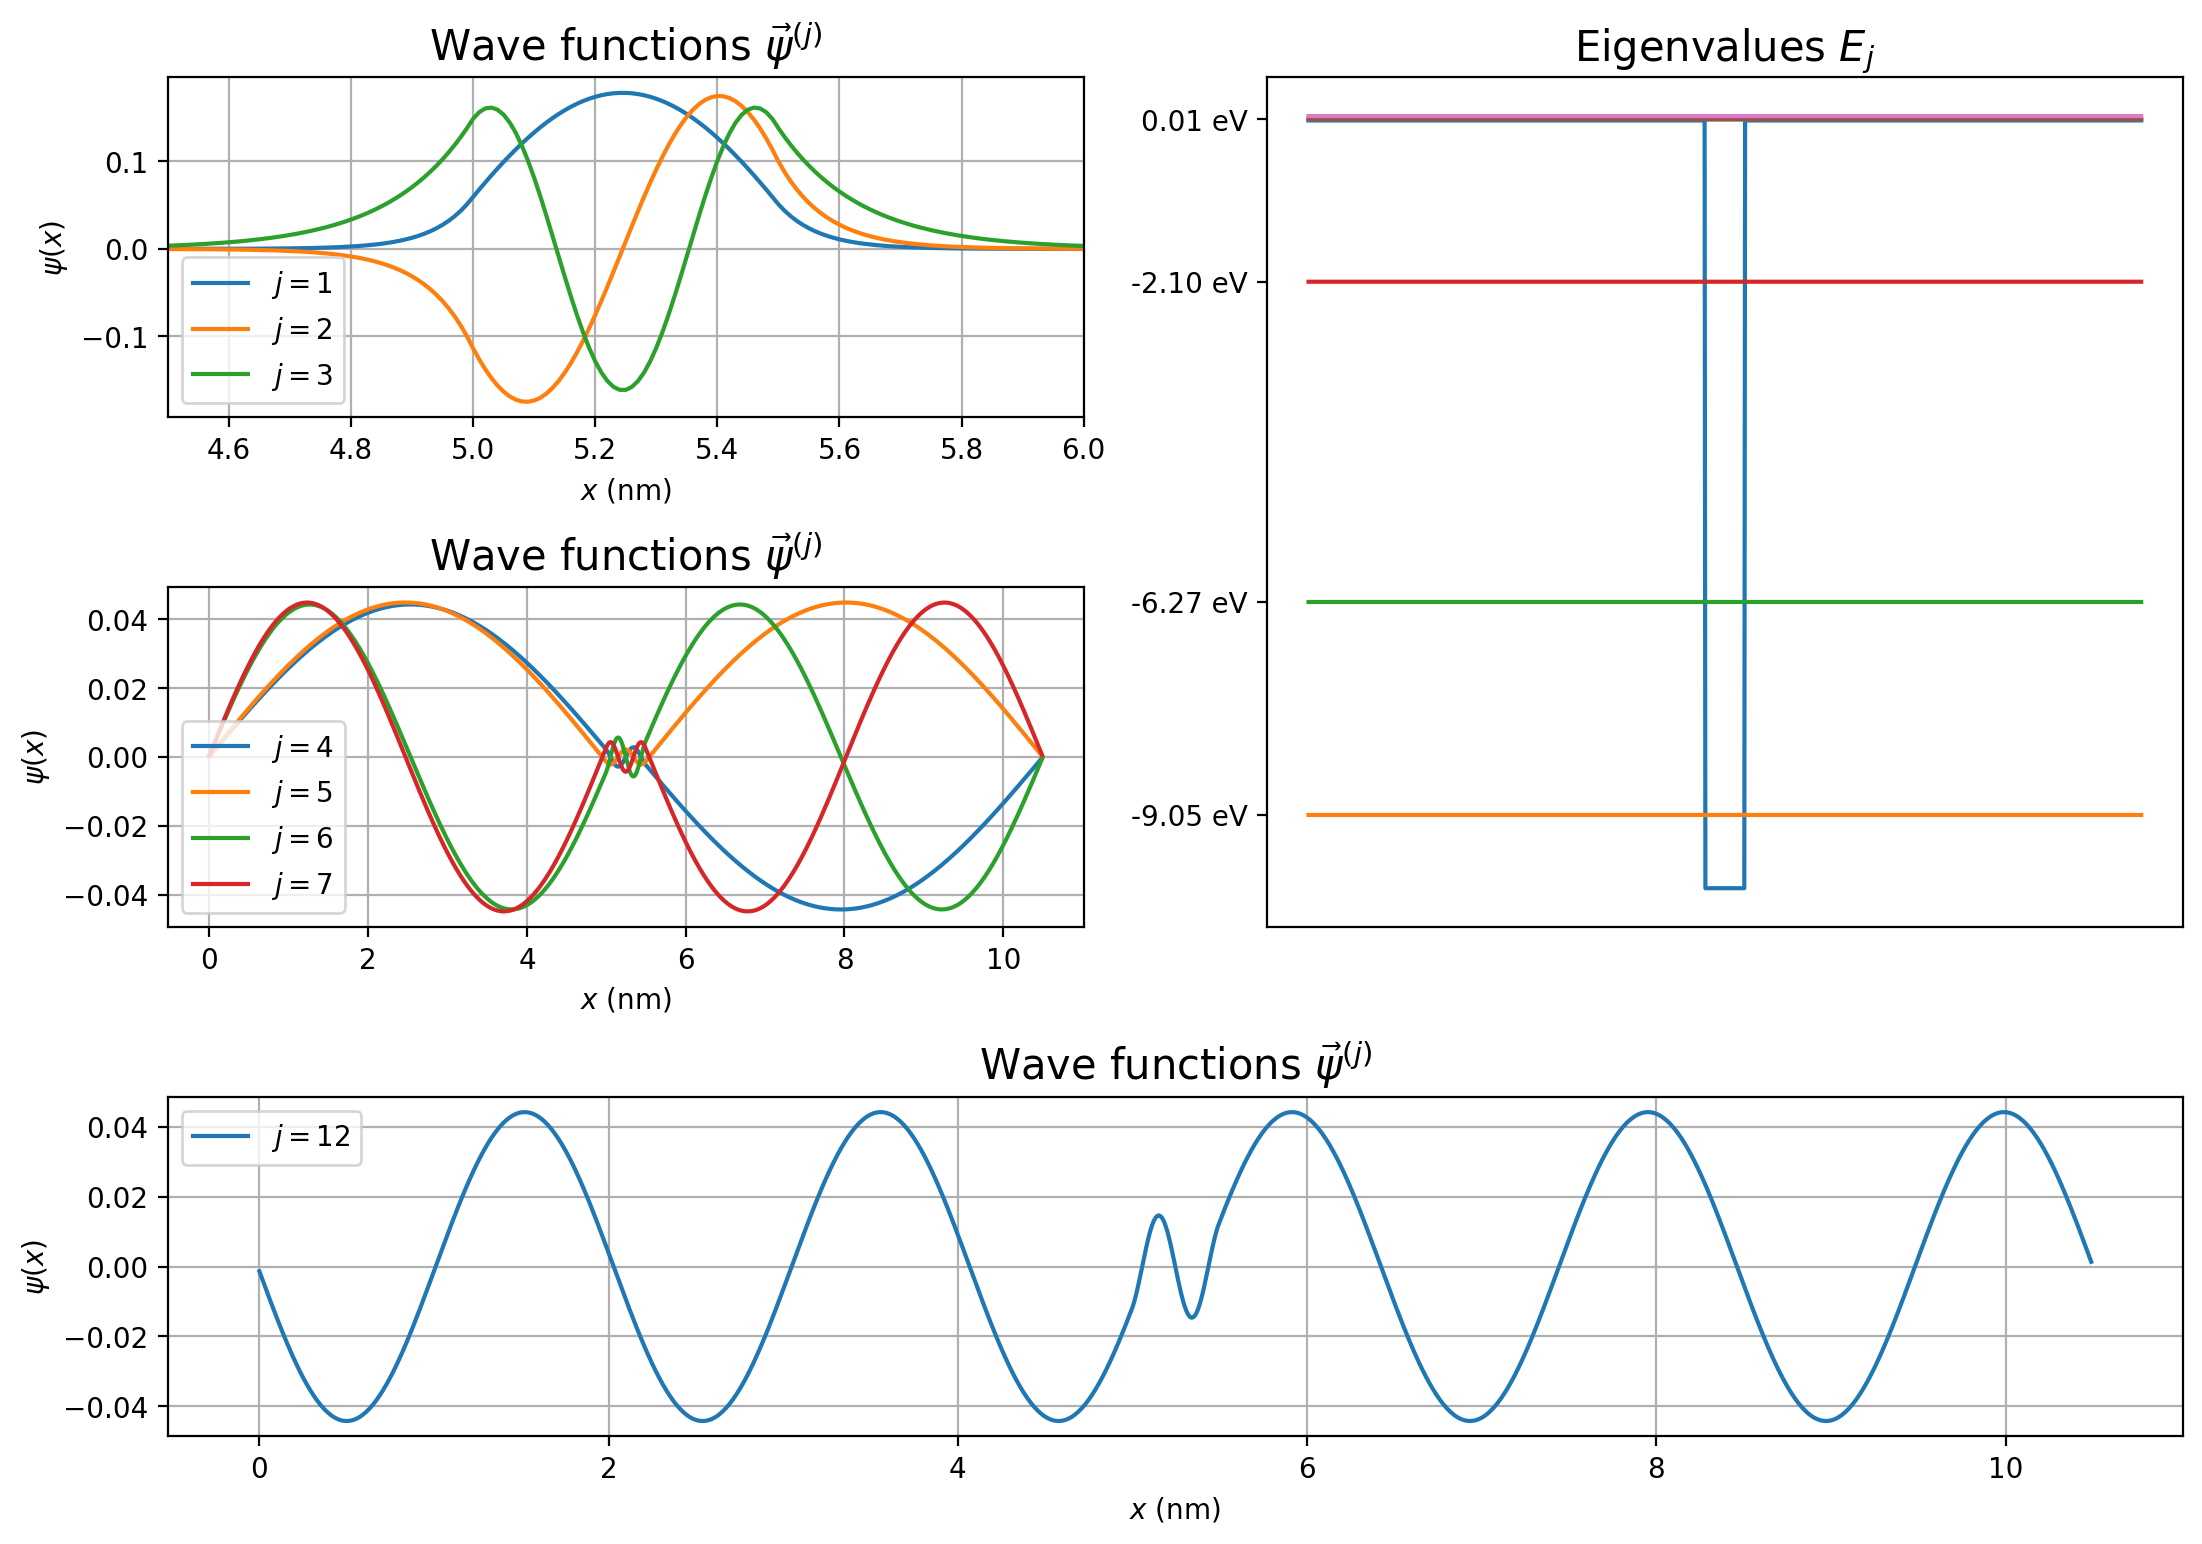

Energy of 4 lowest unbound states: 	 0.014423 eV 	 0.015175 eV 	 0.057664 eV 	 0.060676 eV


In [6]:
dx = 1.0E-11     # Discretisation step length
w = 0.5E-9       # Well width
N = int(w/dx)    # Number of discretisation steps in atom
left = [0]*10*N  # Potential left of atom
atom = [V0]*N    # Potential of atom
right = [0]*10*N # Potential right of atom

# Array of potential values for the system
V = np.asarray(left + atom + right)

eigVec, eigVal, xnm = solveSchrodinger(V)

# Plot the four lowest eigenvalues and eigenvectors
plt.figure("Box Potential", figsize=(13, 9), dpi=200)

plt.subplot(321)
plotEigenVectors(0, 2, eigVec, xnm)
wellStart = len(left)*dx
plt.xlim((wellStart - w)/1.0E-9, (wellStart + 2*w)/1.0E-9)

# Plot higher eigenvalues and their corresponding eigenvectors
plt.subplot(323)
plotEigenVectors(3, 6, eigVec, xnm)

plt.subplot(3, 2, (2, 4))
plotEigenValues(6, eigVal, xnm, True, V)

plt.subplot(3, 2, (5, 6))
plotEigenVectors(11, 11, eigVec, xnm)

plt.subplots_adjust(hspace=0.5)
plt.show()

print("Energy of 4 lowest unbound states: \t %.6f eV \t %.6f eV \t %.6f eV \t %.6f eV"
      %(eigVal[3], eigVal[4], eigVal[5], eigVal[6]))

The upper left plot shows the 3 bound states of the system. The eigenvalues of the next four states are positive, making the contacts classically allowed. We see that the energy separation between these states is relatively small, i.e., we have a quasi-continuous spectrum. Let's plug the eigenvalues of the bound states into the analytical relation above.

In [7]:
factor = np.sqrt(2*m)*w/(2*hbar)
# Energy of the states above the potential well bottom
E1 = eigVal[0]*1.6E-19 - V0
E2 = eigVal[1]*1.6E-19 - V0
E3 = eigVal[2]*1.6E-19 - V0

# Symmetric (S)
# Antisymmetric (AS)
print("\t Ground state (S) \t 1st excited state (AS) \t 2nd excited state (S)")
# Left hand side (LHS)
print("LHS \t %.4f \t\t %.4f  \t\t\t %.4f "%(np.tan(factor*np.sqrt(E1)), 
                                              np.tan(factor*np.sqrt(E2)),
                                              np.tan(factor*np.sqrt(E3))))
# Right hand side (RHS)
print("RHS \t %.4f  \t\t %.4f  \t\t\t %.4f "%(np.sqrt(np.absolute(V0)/E1 - 1),
                                              -np.sqrt(E2/(np.absolute(V0) - E2)),
                                              np.sqrt(np.absolute(V0)/E3 - 1)))

	 Ground state (S) 	 1st excited state (AS) 	 2nd excited state (S)
LHS 	 3.0677 		 -0.7752  			 0.5100 
RHS 	 3.0792  		 -0.7710  			 0.5156 


We get a pretty good match! What about the wavelength relation? The 11th excited state ($j=12$) has an energy of $10.3592 \text{ eV}$ above the well.

In [8]:
# Energy of the 11th excited state above the potential well bottom
E12 = eigVal[11]*1.6E-19 - V0

# Calculating wavelength inside well
kIn = E12
lambIn = 2*np.pi*hbar/np.sqrt(2*m*kIn)
# Converting to nm
lambIn *=1.0E9

# Calculating wavelength outside well (V0 = 0)
kOut = E12 + V0
lambOut = 2*np.pi*hbar/np.sqrt(2*m*kOut)
lambOut *=1.0E9

print("Wavelength inside well:  %.3f nm"%(lambIn))
print("Wavelength outside well: %.3f nm"%(lambOut))

Wavelength inside well:  0.380 nm
Wavelength outside well: 2.039 nm


The wavelength of this wave function should be $0.38$ nm within and $2.0$ nm outside the well potential, which matches very well with the plot of $\psi_{12}$ above.

Assuming non-interacting electrons, which atoms can be constructed with these three bound states? A total of two electrons can occupy each state with opposite spin (fermions, including electrons, have spin 1/2), giving a total of 6 electrons. Thus, this simplified one dimensional model can correspond to Carbon (atomic number 6), Beryllium (4), and Helium (2) with zero total spin, or Boron (5), Lithium (3) and Hydrogen (1) with a total spin 1/2.

In [9]:
# Saving potential and eigenvalues for later use
Vatom = V
eigValAtom = eigVal
xnmAtom = xnm

### The Molecule

Using several potential wells one could simulate some of the behaviour of atoms forming molecules. In the following code we try to describe the twoatomic molecule $\text{H}_2$ and find the binding energy. We create a potential with two potential wells of width $w$ separated by a zero potential barrier of width $b$. On each side of the molecule a zero potential contact of width $10w$ is added.

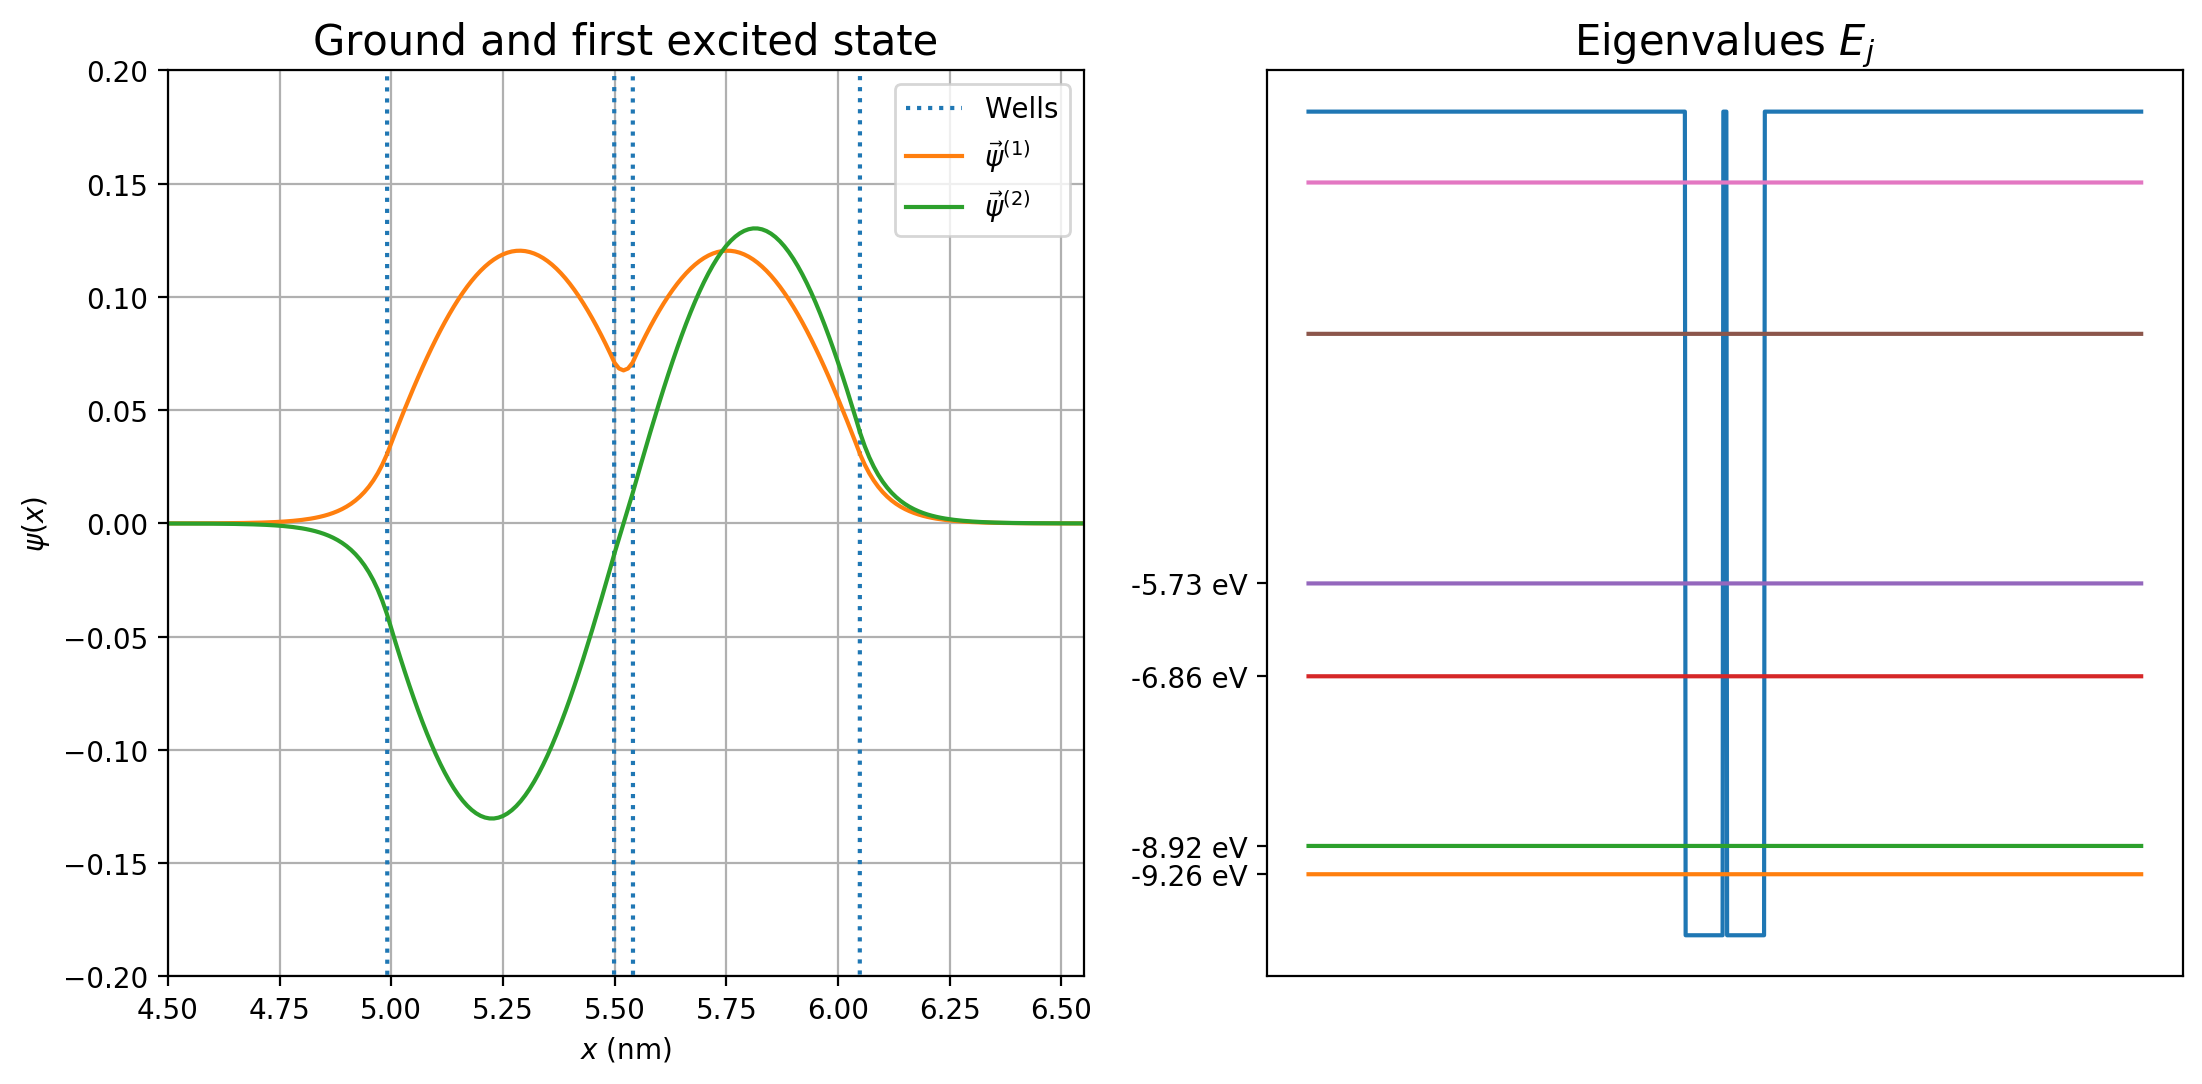

Double well ground state eigenvalue:	-9.2590 eV
Double well 1st excited state eigenvalue:	-8.9156 eV
Single well ground state eigenvalue:	-9.0459 eV


In [10]:
b = w/10           # Atom separation
Nb = int(b/dx)     # Number of discretisation steps between atoms
left = [0]*10*N    # Potential left of atom
atom = [V0]*N      # Potential of atom
separation =[0]*Nb # Potential of separation
right = [0]*10*N   # Potential right of atom

# Array of potential values for the system
V = np.asarray(left + atom + separation + atom + right)

eigVec, eigVal, xnm = solveSchrodinger(V)

# Plot the six lowest eigenvalues and the two lowest eigenvectors
plt.figure("Molecule", figsize=(13, 6), dpi=(200))
plt.subplot(121)
plt.title(r'Ground and first excited state', fontsize=15)
plt.plot(xnm, V/1.6E-19 + 1, ':', label=r'Wells')
for i in range(2):
    plt.plot(xnm, eigVec[:, i], label=r'$\vec{\psi}^{(%.i)}$'%(i + 1))
plt.xlabel('$x$ (nm)')
plt.ylabel('$\psi(x)$')
plt.grid(True)
plt.legend()
plt.xlim((wellStart - w)/1.0E-9, (wellStart + b + 3*w)/1.0E-9)
plt.ylim(-0.2, 0.2)

plt.subplot(122)
plotEigenValues(6, eigVal, xnm, True, V)

plt.show()

print("Double well ground state eigenvalue:\t%.4f eV"%(eigVal[0]))
print("Double well 1st excited state eigenvalue:\t%.4f eV"%(eigVal[1]))

print("Single well ground state eigenvalue:\t%.4f eV"%(eigValAtom[0]))

When the two potential wells are sufficiently close together, we see that additional bound states occur. Molecular eigenstates can be viewed as linear combinations of atomic eigenstates. The eigenvectors of the two lowest eigenvalues are plotted above. The double well ground state eigenvector is essentially a symmetric combination of the ground state in two separate single wells (atoms), with an eigenvalue $0.2131 \text{ eV}$ lower than the ground state eigenvalue of a single atom. The first excited state of the double well is essentially an antisymmetric combination of the two single atom ground states, with an eigenvalue $0.1303\text{ eV}$ higher than the ground state eigenvalue of a single atom. Let us plot the probability distribution of these two molecular states. 

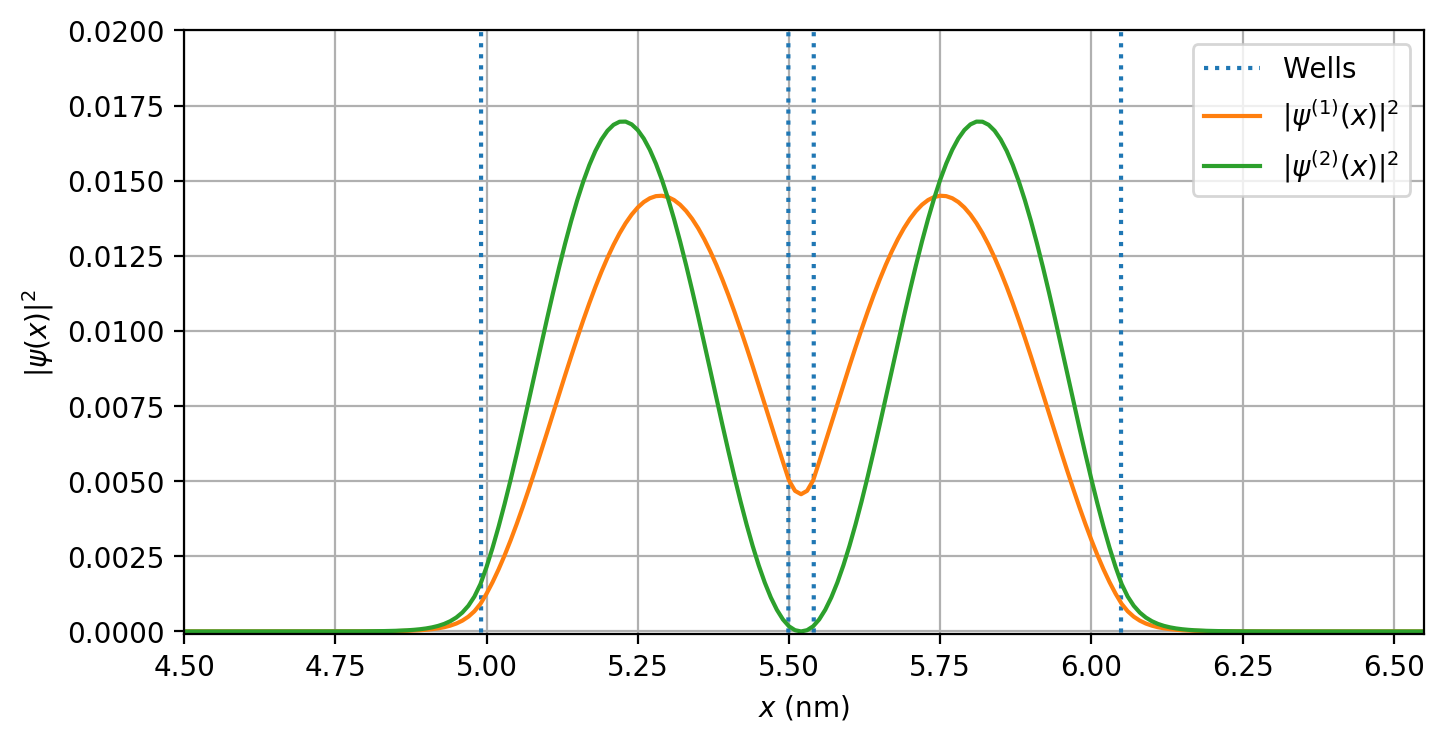

In [11]:
plt.figure(figsize=(8, 4), dpi=200)
plt.plot(xnm, V/1.6E-19 + 1, ':', label=r'Wells')
plt.plot(xnm, np.absolute(eigVec[:,0])**2, label=r'$|\psi^{(1)}(x)|^2$')
plt.plot(xnm, np.absolute(eigVec[:,1])**2, label=r'$|\psi^{(2)}(x)|^2$')
plt.xlabel('$x$ (nm)')
plt.ylabel('$|\psi(x)|^2$')
plt.xlim((wellStart - w)/1.0E-9, (wellStart + b + 3*w)/1.0E-9)
plt.ylim(-0.0001, 0.02)
plt.grid(True)
plt.legend()
plt.show()

The ground state eigenvector yields a high probability density between the two atoms. The energy of this double well ground state is lower than the ground state energy of a single well (an individual atom). One electron from each atom can occupy this state with opposite spin, forming a chemical bond between the two atoms, i.e., a molecule. The binding energy equals the energy difference between the molecule and the sum of the energies of two separate atoms:

\begin{equation}
\Delta E = 2E_{\text{atom}} - E_{\text{molecule}}.
\label{bindingEnergy}
\end{equation}

The simplest case is the hydrogen molecule $\text{H}_2$. Separately, each electron of a hydrogen atom occupies the ground state of the individual **atom** (calculated earlier in "The Atom"). In the molecule, the two electrons both occupy the ground state of the **molecule**, with opposite spin. Hence, the binding energy becomes

$$ \Delta E = -9.0459\text{ eV} \cdot 2 - 2E_{1, \text{molecule}}$$

for the molecule $\text{H}_2$.

In [12]:
deltaE = 2*-9.0459 - 2*eigVal[0]
print("Binding energy for the hydrogen molecule: %.4f eV"%(deltaE))

Binding energy for the hydrogen molecule: 0.4263 eV


The first excited state of the molecule, however, shows a close to zero probability density in the region between the atoms. The state also has an energy higher than the ground state energy of an individual atom, indicating an anti-bonding molecular orbital. Thus, as a model for $\text{He}_2$, we have the individual $\text{He}$ energy

$$ E_{\text{He, atom}} = -9.0459\text{ eV} \cdot 2, $$

where the factor two is because $\text{He}$ has two electrons, and the molecular energy

$$ E_{\text{He}_2\text{, molecule}} = 2E_{1, \text{molecule}} + 2E_{2, \text{molecule}} ,$$

giving the binding energy:

In [13]:
deltaE = 4*-9.0459 - (2*eigVal[0] + 2*eigVal[1])
print("Binding energy for the helium molecule: %.4f eV"%(deltaE))

Binding energy for the helium molecule: 0.1656 eV


This is much smaller than the binding energy of $\text{H}_2$, as expected. In "the real world", the helium dimer is not stable.

### The Crystal
With $N_w$ potential wells next to each other, with zero potential barrier separations of width $b$, one can simulate a crystal.

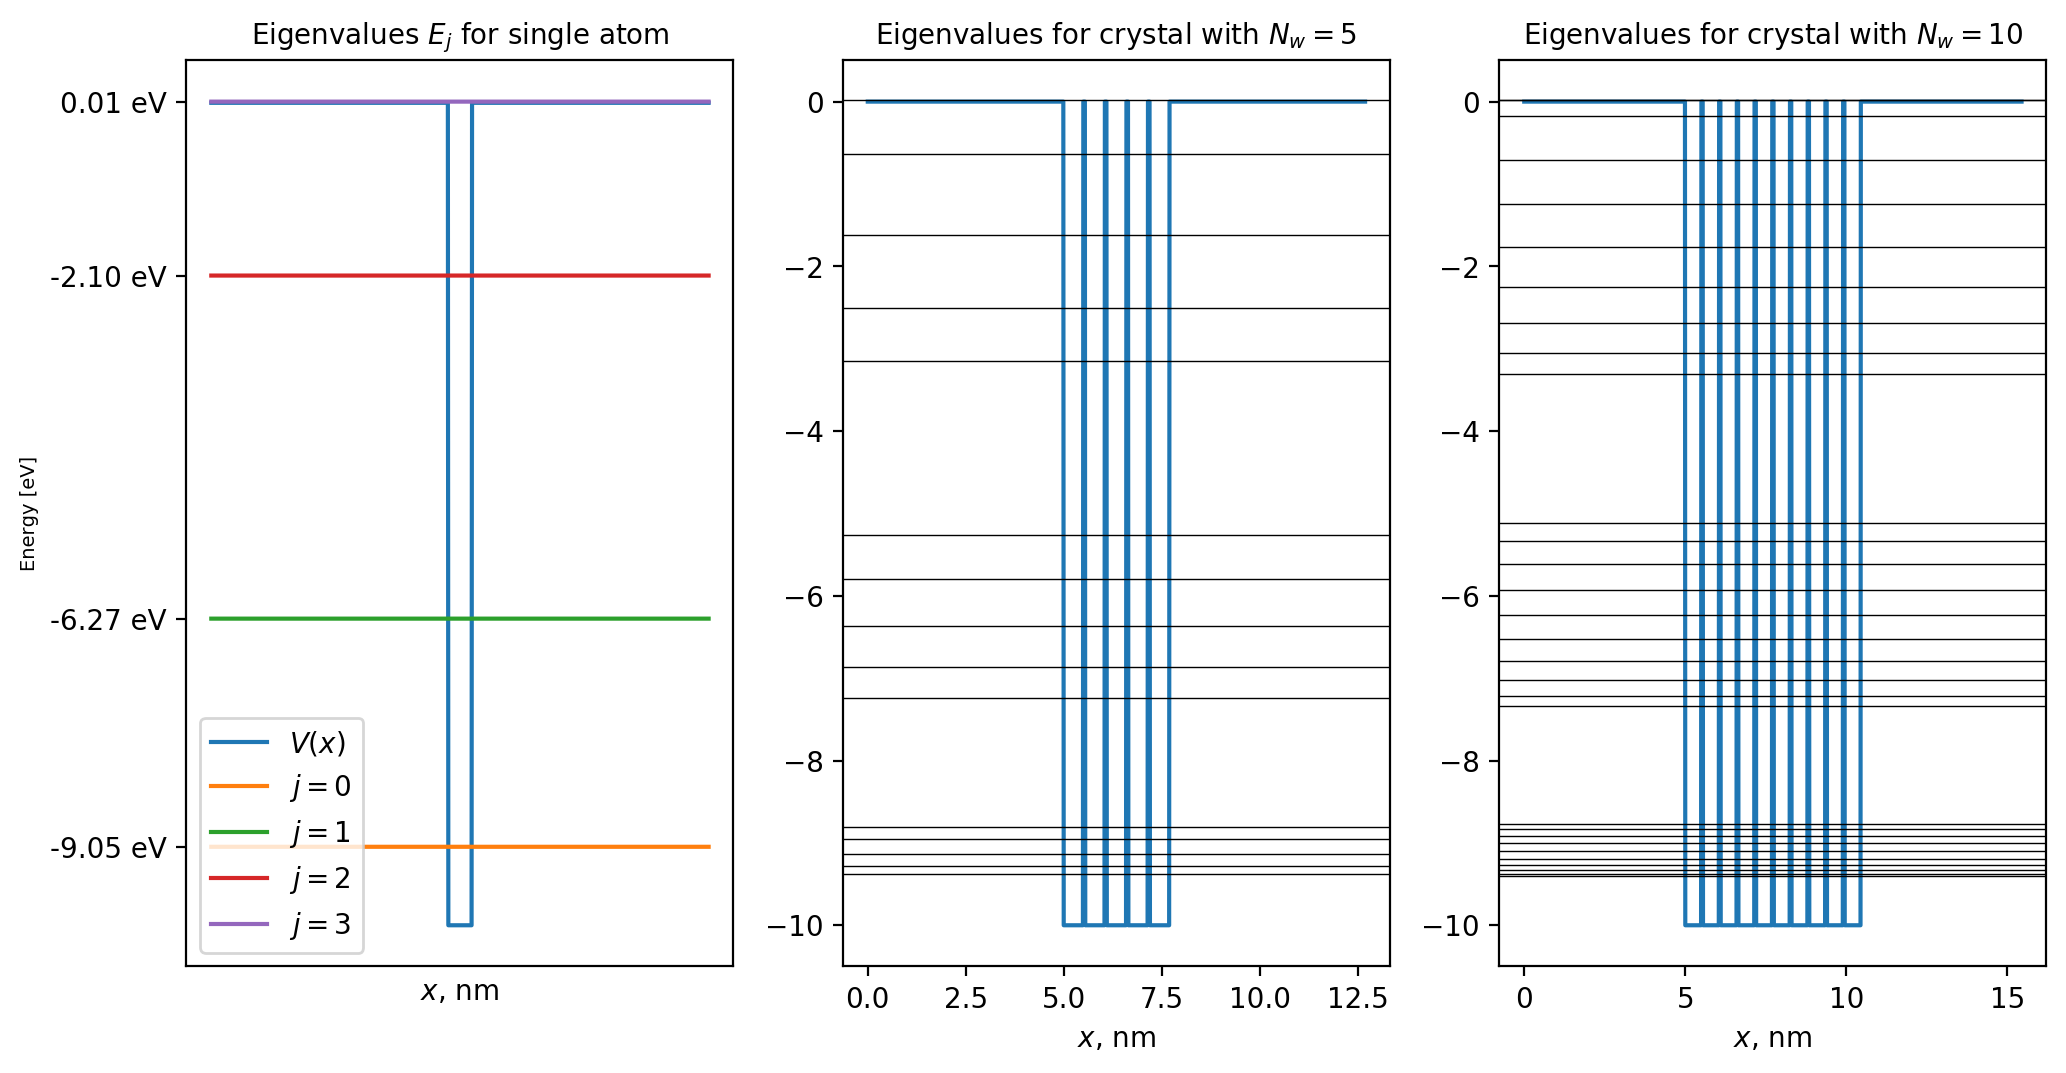

In [14]:
Nw = 5 # Number of potential wells

# Array of potential values for the system
V = np.asarray(left + (atom + separation)*(Nw - 1) + atom + right)
Ntot = len(V)

# Find eigenvectors and values
eigVec, eigVal, xnm = solveSchrodinger(V)

plt.figure(figsize=(12, 6), dpi = 200)
plt.subplot(131)
plotEigenValues(4, eigValAtom, xnmAtom, True, Vatom)
plt.title(r'Eigenvalues $E_j$ for single atom', fontsize=10)
plt.ylabel("Energy [eV]", fontsize=7)
plt.xlabel(r'$x$, nm')
plt.legend()

ax = plt.subplot(132)
plt.title(r'Eigenvalues for crystal with $N_w = %.i$'%(Nw), fontsize=10)
ax.plot(xnm, V/1.6E-19, label=r'$V(x)$')
for i in range(Nw*3):
    l = plt.axhline(eigVal[i], linewidth=.5, color='black')
plt.xlabel(r'$x$, nm')

# Repeat with ten atoms
Nw = 10
V = np.asarray(left + (atom + separation)*(Nw - 1) + atom + right)
Ntot = len(V)
eigVec, eigVal, xnm = solveSchrodinger(V)

ax = plt.subplot(133)
plt.title(r'Eigenvalues for crystal with $N_w = %.i$'%(Nw), fontsize=10)
ax.plot(xnm, V/1.6E-19, label=r'$V(x)$')
for i in range(Nw*3):
    l = plt.axhline(eigVal[i], linewidth=.5, color='black')
plt.xlabel(r'$x$, nm')

plt.subplots_adjust(hspace=0.5)
plt.show()

Notice the appearance of energy bands with $N_w$ energy levels around each bound state energy of the single atom. The bandwidths and bandgaps are printed below.

In [15]:
print("\t\t\t 1st band \t 2nd band \t 3rd band")
print("Lowest energy level \t %.4f eV \t %.4f eV \t %.4f eV"
      %(eigVal[0], eigVal[Nw], eigVal[2*Nw]))
print("Highest energy level \t %.4f eV \t %.4f eV \t  %.4f eV \t"
      %(eigVal[Nw-1], eigVal[2*Nw-1], eigVal[3*Nw-1]))
print("Bandwidth\t\t  %.4f eV \t  %.4f eV \t  %.4f eV"%(eigVal[Nw-1] - eigVal[0], 
                                                     eigVal[2*Nw-1] - eigVal[Nw],
                                                     eigVal[3*Nw-1] - eigVal[2*Nw]))
print("Bandgap\t\t\t\t\t  %.4f eV \t  %.4f eV"%(eigVal[Nw] - eigVal[Nw-1], 
                                              eigVal[2*Nw] - eigVal[2*Nw-1]))

			 1st band 	 2nd band 	 3rd band
Lowest energy level 	 -9.4063 eV 	 -7.3352 eV 	 -3.3051 eV
Highest energy level 	 -8.7750 eV 	 -5.1116 eV 	  0.0155 eV 	
Bandwidth		  0.6313 eV 	  2.2236 eV 	  3.3206 eV
Bandgap					  1.4398 eV 	  1.8066 eV


For selected values of $N_w$ between $2$ and $100$ we plot the bandwidths of the three lowest bands. 

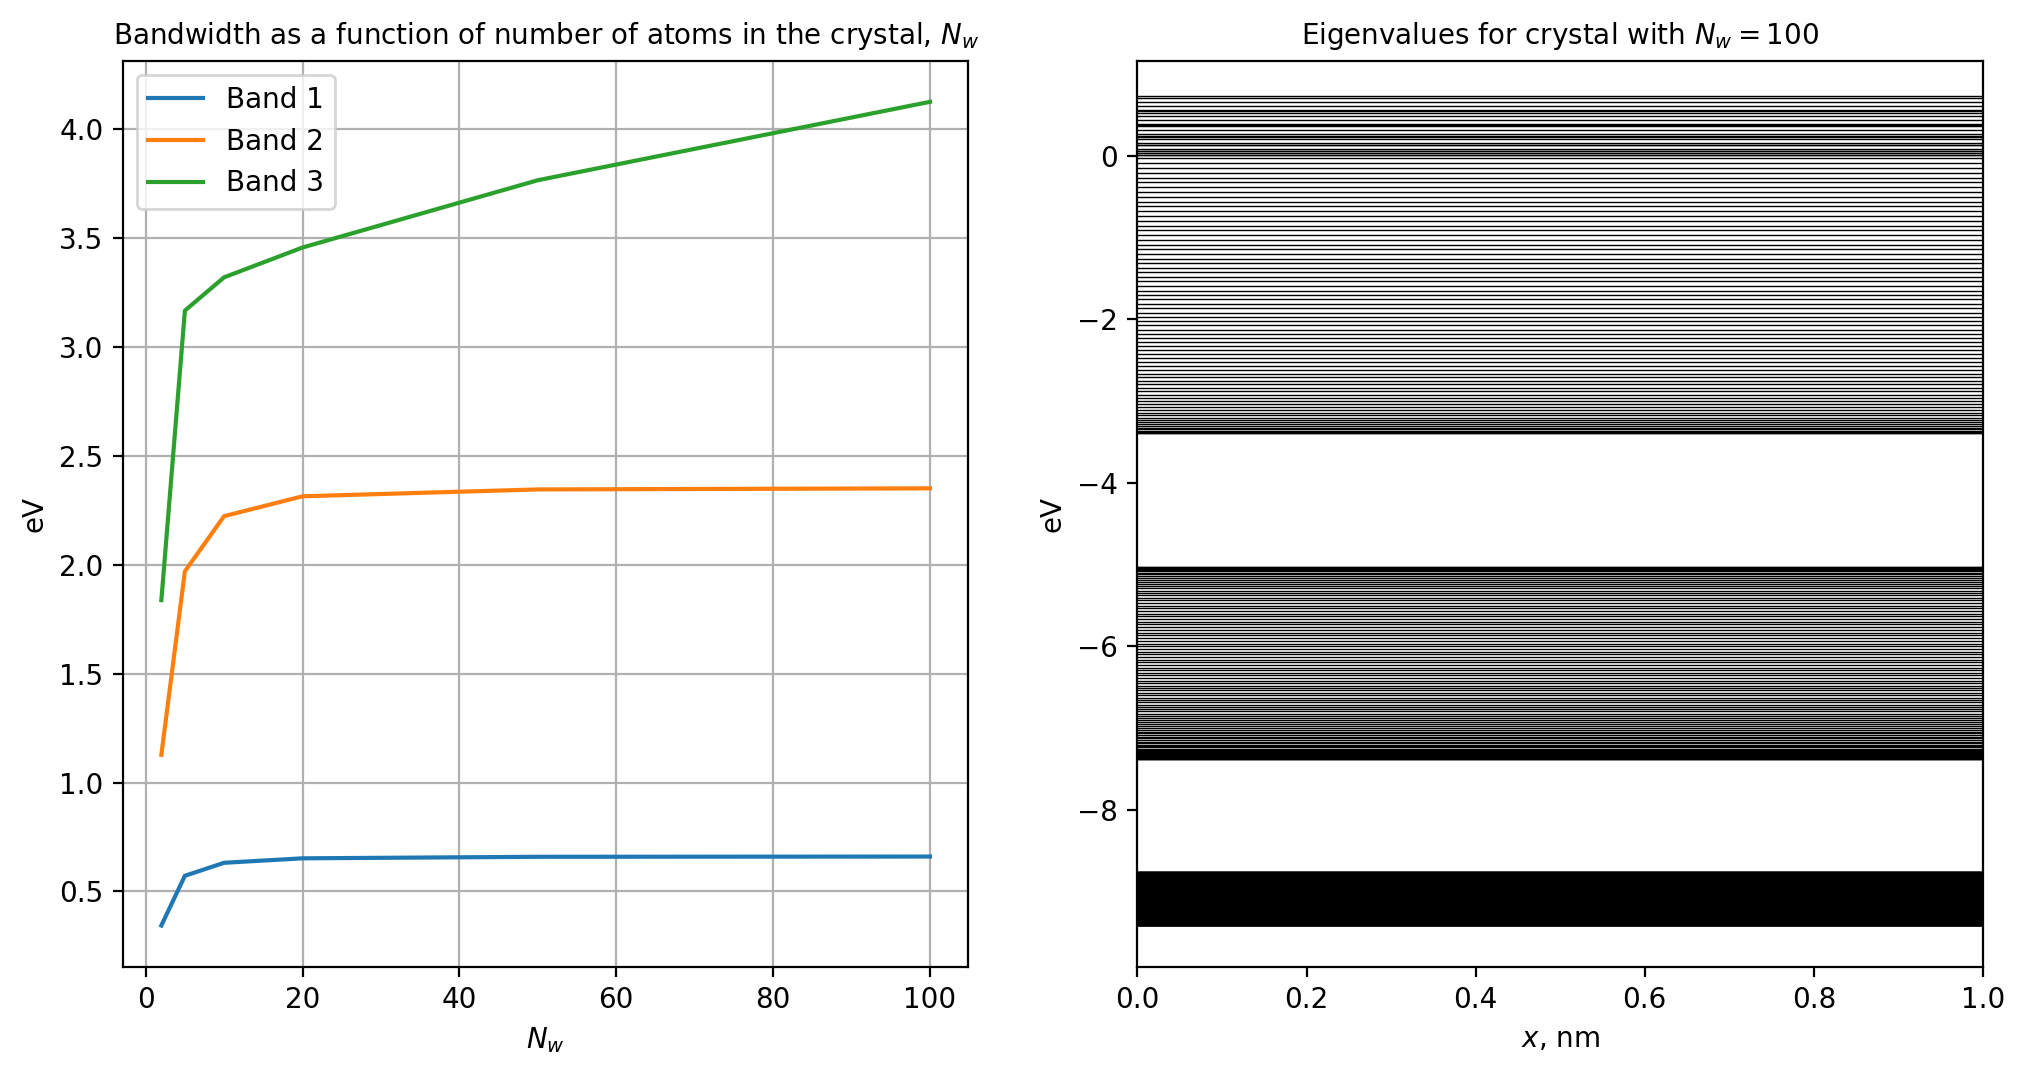

In [16]:
NwSelected = [2, 5, 10, 20, 50, 100]         # Selected atom numbers
bandwidths = np.zeros((3, len(NwSelected)))  # Initialising matrix storing bandwidths

for i in range(len(NwSelected)):
    Nw = NwSelected[i]
    V = np.asarray(left + (atom + separation)*(Nw - 1) + atom + right)
    eigVec, eigVal, xnm = solveSchrodinger(V)
    bandwidths[0, i] = eigVal[Nw-1] - eigVal[0]
    bandwidths[1, i] = eigVal[2*Nw-1] - eigVal[Nw]
    bandwidths[2, i] = eigVal[3*Nw-1] - eigVal[2*Nw]

plt.figure(figsize=(12, 6), dpi=200)
plt.subplot(121)
plt.title(r"Bandwidth as a function of number of atoms in the crystal, $N_w$", fontsize=10)
plt.plot(NwSelected, bandwidths[0, :], label="Band 1")
plt.plot(NwSelected, bandwidths[1, :], label="Band 2")
plt.plot(NwSelected, bandwidths[2, :], label="Band 3")
plt.xlabel(r"$N_w$")
plt.ylabel("eV")
plt.grid()
plt.legend()

ax = plt.subplot(122)
plt.title(r'Eigenvalues for crystal with $N_w = %.i$'%(Nw), fontsize=10)
for i in range(Nw*3):
    l = plt.axhline(eigVal[i], linewidth=.5, color='black')
plt.xlabel(r'$x$, nm')
plt.ylabel("eV")
plt.show()

The width of the two lowest bands approaches a constant value as $N_w$ increases. Thus, with a high enough number of atoms, we have an energy band with approximately continuous distribution of energy levels.

The constant bandwidths and bandgaps differ with the type of crystal (material). Say each atom in a crystal has four electrons each, we then have $4N_w$ electrons in total. Two electrons with opposite spin can occupy the same orbital leaving the $2N_w$ lowest energy levels - the two lowest bands - filled (a sufficiently low temperature is required). With $N_w = 100$ the two "most energetic" electrons have energy

In [17]:
print("%.4f eV."%(eigVal[2*Nw-1]))

-5.0268 eV.


If the gap to the next energy band is larger than $2-3$ eV, then the crystal is an insulator [[1]](#rsc). If the gap is smaller than $2-3$ eV but larger than zero, it is a semiconductor.

In [18]:
print("Bandgap between first and second band: %.4f eV"%(eigVal[Nw] - eigVal[Nw - 1]))
print("Bandgap between second and third band: %.4f eV"%(eigVal[2*Nw] - eigVal[2*Nw - 1]))

Bandgap between first and second band: 1.3774 eV
Bandgap between second and third band: 1.6330 eV


Hence, our crystal is a semiconductor.

#### Bloch's Theorem
In a periodic potential with lattice constant $a$, $V(x + na) = V(x), n \in \mathbb{Z}$, the solutions of the time independent SchrÃ¶dinger equation takes the form

\begin{equation}
\psi (x) = e^{ikx}u_k(x).
\label{Bloch}
\end{equation}

where $u_k$ has the same periodicity as the potential,

$$ u_k(x + na) = u_k(x), $$

and $k$ is the wavenumber of the electron. This is Bloch's Theorem [[3]](#rsc). The wave function $\psi$ is often called a *Bloch Wave*.

In a crystal, the lattice constant $a$ is the distance between each lattice point, i.e. atom. With a finite number of atoms in the crystal and the condition $\psi = 0$ on the two "surfaces" of the crystal, then $\psi$ becomes

$$ \psi(x) = u_k(x)\sin k x \;\; ; \;\; k_j = \frac{j\pi}{Na} \; (j = 1, 2, \dots) .$$

Here $N$ is the number of atoms in the crystal; hence $Na$ is its length.

In our one dimensional crystal we have the lattice constant $a = w+b$ giving the total length $Na = N_w(w + b)$, and a Bloch wavelength $\lambda = 2\pi/k_j = 2N_w(w + b)/j$.

Bloch wavelength for j = 1: 11.00 nm
Bloch wavelength for j = 2: 5.50 nm
Bloch wavelength for j = 3: 3.67 nm


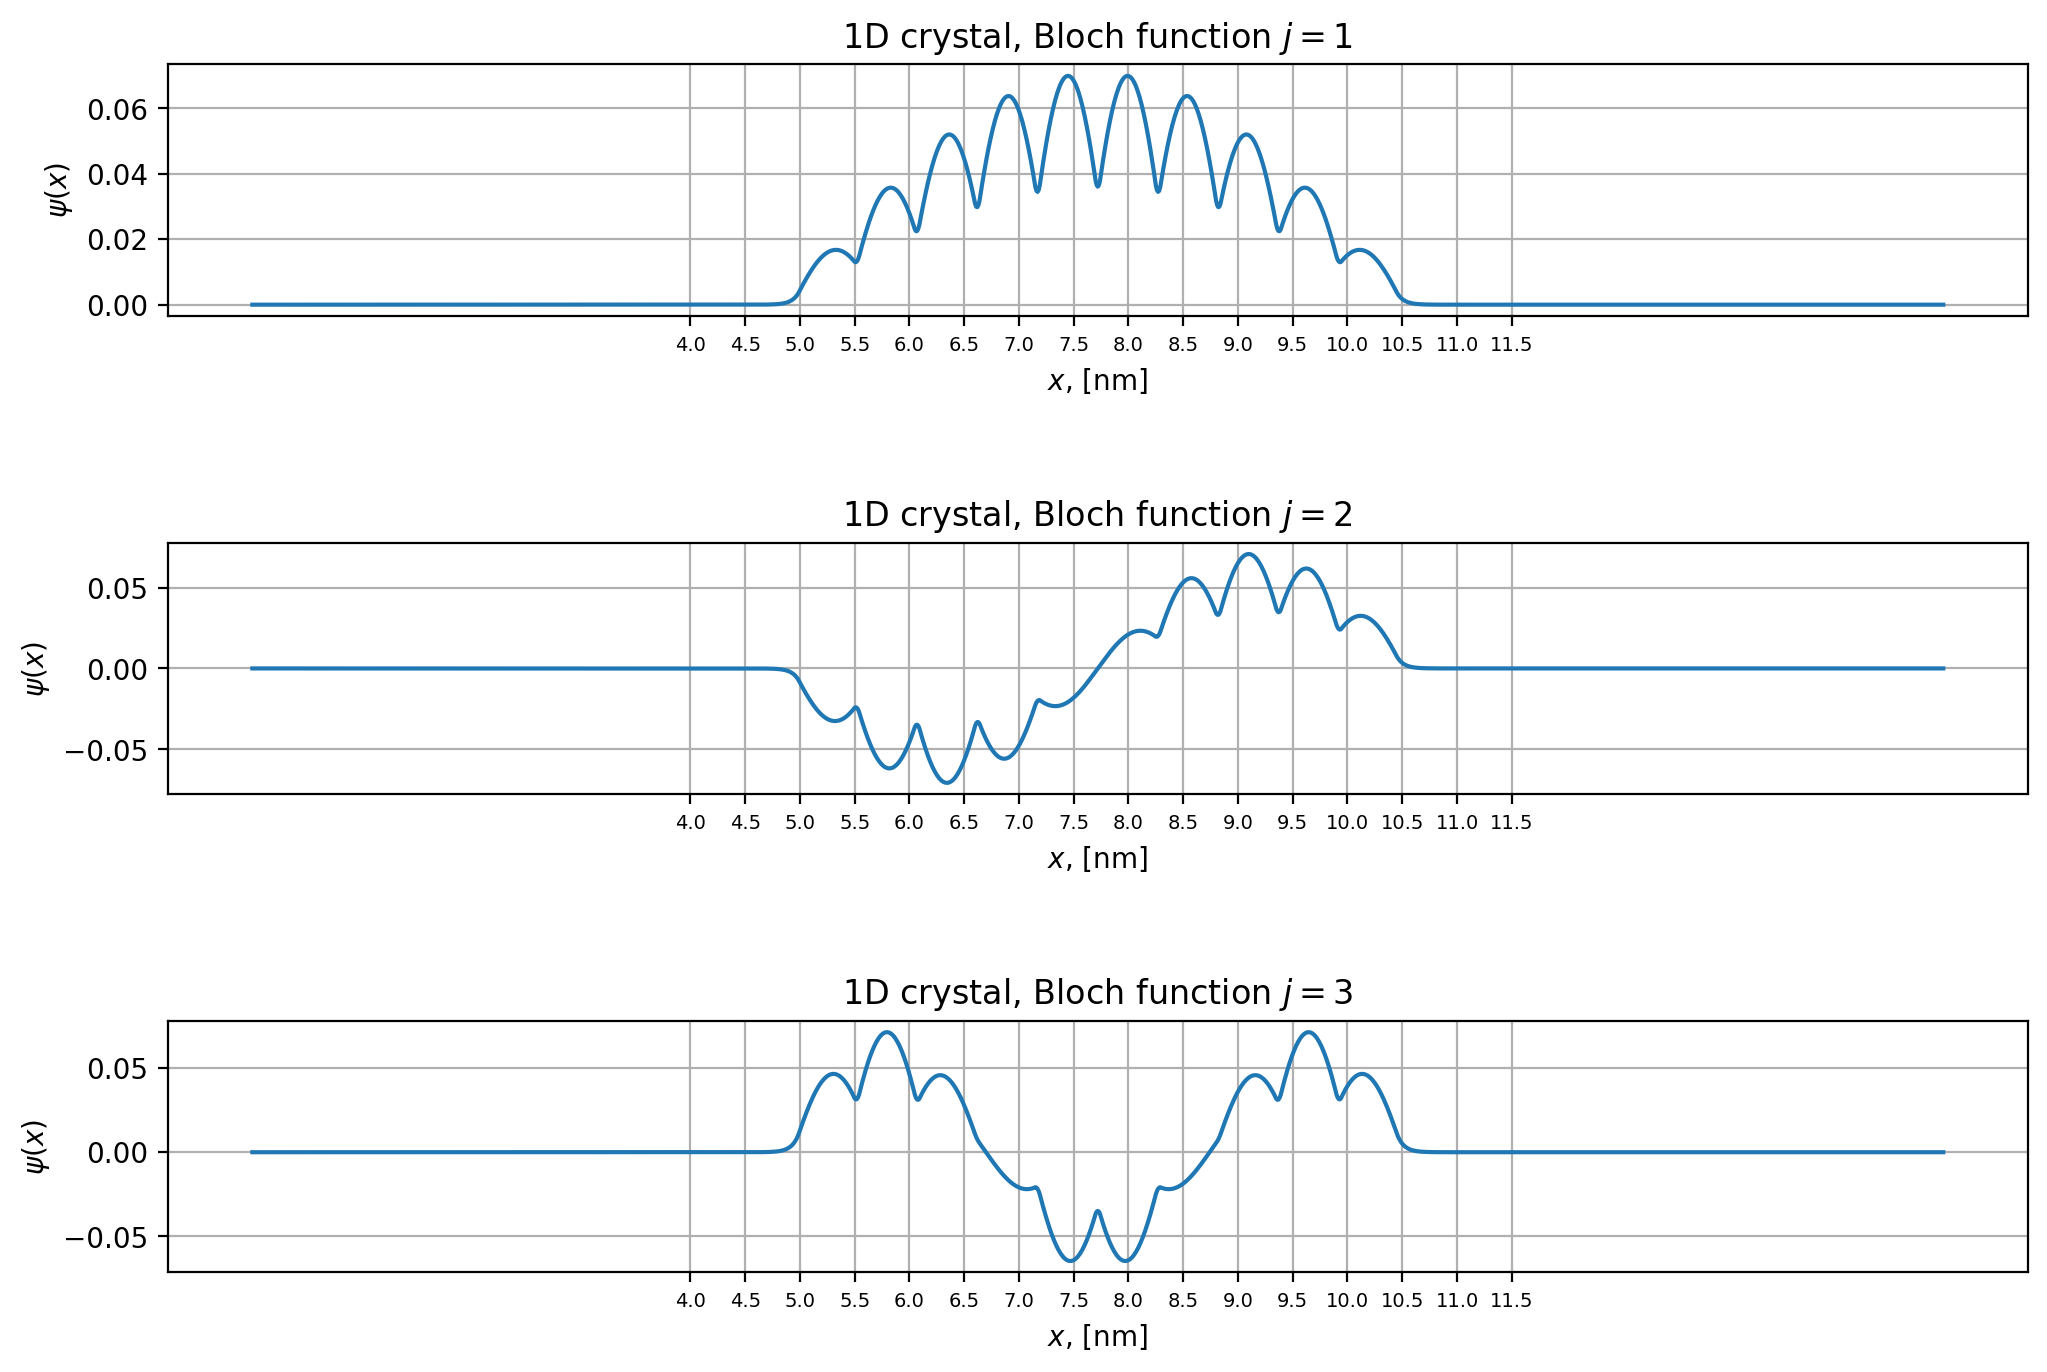

In [19]:
Nw = 10
V = np.asarray(left + (atom + separation)*(Nw - 1) + atom + right)
eigVec, eigVal, xnm = solveSchrodinger(V)

plt.figure(figsize=(12, 8), dpi=200)
l = 4
for j in range(1, l):    # Here j is the wave number 
    lam = 2*Nw*(w + b)/j # Wavelength of Bloch wave
    lam *= 1/1e-9        # converting to nm
    print("Bloch wavelength for j = %.i: %.2f nm"%(j, lam))
    
    plt.subplot(l-1, 1, j)
    plt.title(r"1D crystal, Bloch function $j = %.i$"%(j))
    plt.plot(xnm, eigVec[:, j - 1], label='Computed wave')
    plt.xlabel(r'$x$, [nm]')
    plt.ylabel(r'$\psi (x)$')
    plt.xticks(np.arange(4, 12, .5), np.arange(4, 12, .5), fontsize=7)
    plt.grid()

plt.subplots_adjust(hspace=0.9)
plt.show()

From the plots above we see that the computed wavelength matches perfectly with the corresponding Bloch wave! By using low energy states, the wave function will not penetrate far into the crystal boundaries. The three states with lowest energy have all ten crests each, caused by the periodic function $u(x)$.

___

<a id="rsc"></a>
## Resources and Further Reading
<a>[1]</a> J. A. StÃ¸vneng, February 2019, [*TFY4215 InnfÃ¸ring i kvantefysikk. TMA4320 Introduksjon til vitenskapelige beregninger. Fysikkprosjekt: Endimensjonale modeller for atomer, molekyler og krystaller*](), Norwegian University of Science and Technology

<a>[2]</a> P.C. Hemmer, *Kvantemekanikk*, 5th edition, 2005, Fagbokforlaget

<a>[3]</a> C. Kittel, *Introduction to Solid State Physics*, 8th edition, 2005, John Wiley & Sons, Inc